# **Age Estimation**

<div>
  <img
    src="https://www.thedrvibeshow.com/wp-content/uploads/2021/06/Facial-Recognition-Is-Sinister.-Why-Does-It-Exist.jpg"
    alt="Drawing"
    style="width: 100;"
  />
</div>

# 🔴 **Connect Google Colab to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🔴 **Install Required Packages**

In [ ]:
!pip install torchmetrics
!pip install face-recognition

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# 🔴 **Imports**

In [ ]:
import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

import face_recognition

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm, face_recognition]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
pandas --> 2.1.4
cv2 --> 4.10.0
PIL --> 9.4.0
sklearn --> 1.3.2
torch --> 2.3.1+cu121
torchvision --> 0.18.1+cu121
tqdm --> 4.66.5
torchmetrics --> 1.4.1
face_recognition --> 1.2.3


# 🔴 **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 Copy & Unzip the Dataset

In [ ]:
!tar -xzf '/content/drive/MyDrive/UTKFace.tar.gz' -C '/content/'

* x: This flag stands for "extract". It tells the tar command to extract the files from the archive.

* v: This flag stands for "verbose". It displays the list of files being extracted in the terminal.

* z: This flag indicates that the archive file is compressed using gzip.

* f: This flag indicates that the following argument is the name of the archive file.

## 🟠 EDA

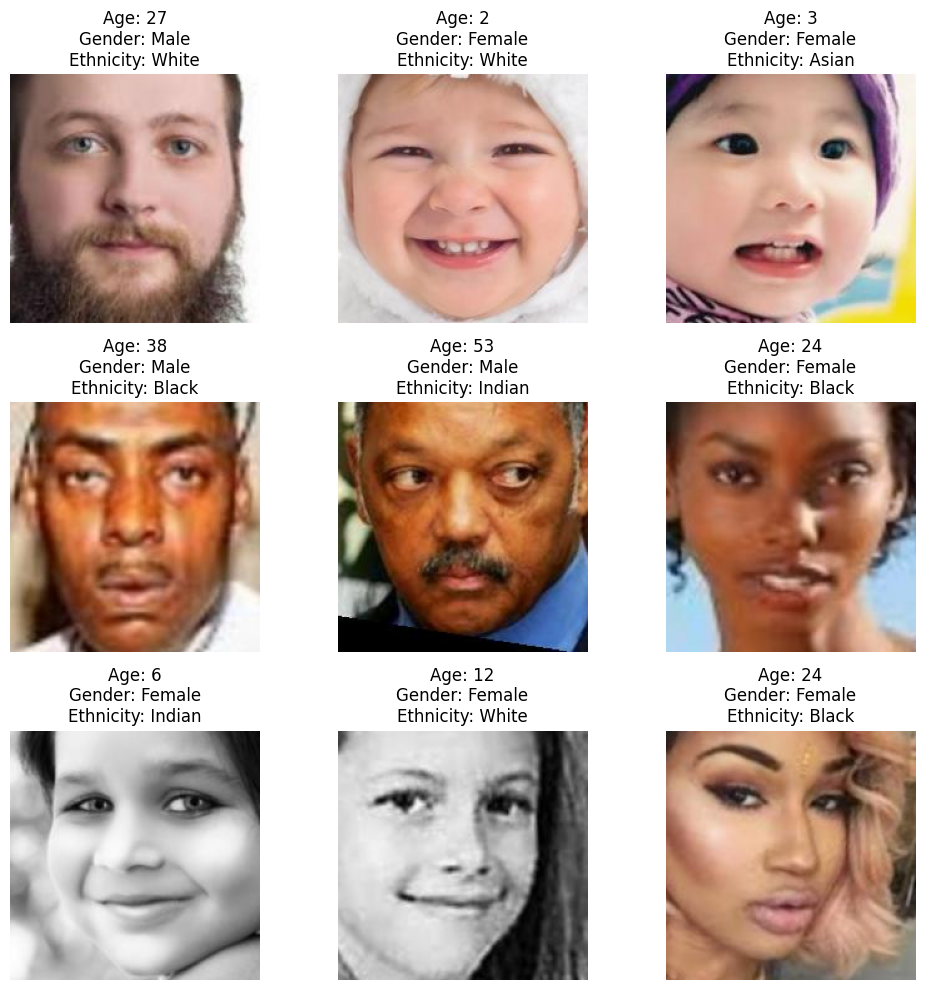

In [ ]:
dataset_folder = '/content/UTKFace/'


def show_random_samples(num_samples=9):
    image_files = os.listdir(dataset_folder)
    selected_image_files = random.sample(image_files, num_samples)

    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path = os.path.join(dataset_folder, image_file)
        age, gender, ethnicity = image_file.split('_')[:3]

        image = Image.open(image_path)

        gender = 'Male' if int(gender) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


show_random_samples()

### 🟡 Converting dataset to csv file

In [ ]:
dataset_dir = '/content/UTKFace'

image_names, ages, ethnicities, genders  = [], [], [], []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.jpg'):
        parts = filename.split('_')

        if len(parts) < 4:
          print(filename)
          continue

        # Format: [age]_[gender]_[ethnicity]_[other-info].jpg
        age = int(parts[0])
        gender = 'Male' if int(parts[1]) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(parts[2])]

        if age > 80:
          continue

        image_names.append(filename)
        ages.append(age)
        ethnicities.append(ethnicity)
        genders.append(gender)


# Create a Dataframe from the lists
data = {
    'image_name': image_names,
    'age': ages,
    'ethnicity': ethnicities,
    'gender': genders
}
df = pd.DataFrame(data)

csv_filename = '/content/utkface_dataset.csv'
df.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' created successfully.")

61_1_20170109150557335.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
39_1_20170116174525125.jpg.chip.jpg
CSV file '/content/utkface_dataset.csv' created successfully.


In [ ]:
df.head()

,image_name,age,ethnicity,gender
0,50_0_0_20170117135739223.jpg.chip.jpg,50,White,Male
1,12_0_0_20170110225348936.jpg.chip.jpg,12,White,Male
2,40_1_0_20170117150751092.jpg.chip.jpg,40,White,Female
3,22_1_2_20170116172549492.jpg.chip.jpg,22,Asian,Female
4,33_1_1_20170116215201422.jpg.chip.jpg,33,Black,Female


### 🟡 Age histogram

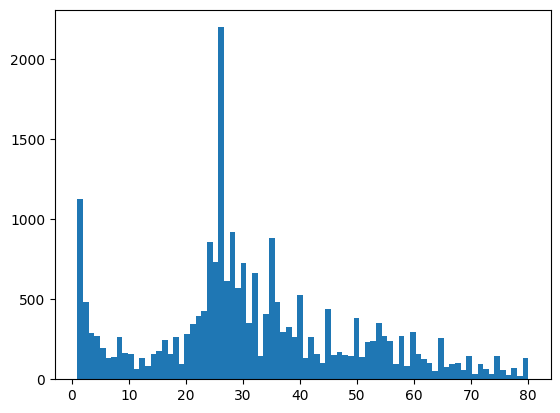

In [ ]:
plt.hist(df.age, bins=len(df.age.unique()));

In [ ]:
df.age.describe()

,age
count,23165.000000
mean,32.024218
std,18.227409
min,1.000000
25%,23.000000
50%,29.000000
75%,42.000000
max,80.000000


### 🟡 Gender histogram

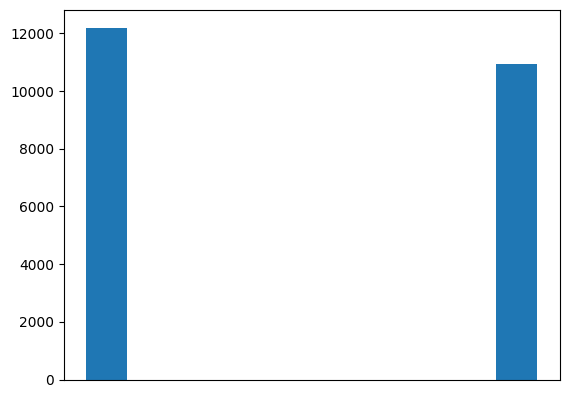

In [ ]:
plt.hist(df.gender, bins=2, rwidth=0.1);

In [ ]:
df.gender.value_counts()

,count
gender,
Male,12208
Female,10957


### 🟡 Ethnicity histogram

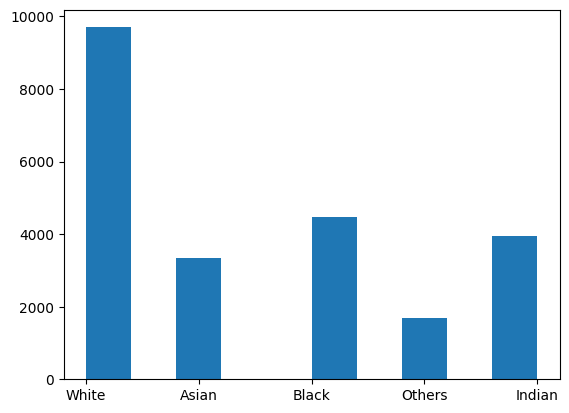

In [ ]:
plt.hist(df.ethnicity);

In [ ]:
df.ethnicity.value_counts()

,count
ethnicity,
White,9698
Black,4478
Indian,3952
Asian,3348
Others,1689


### 🟡 Gender and Ethnicity cross-tabulation

In [ ]:
pd.crosstab(index=df.gender, columns=df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1810,2182,1698,930,4337
Male,1538,2296,2254,759,5361


In [ ]:
pd.crosstab(index=df.ethnicity, columns=df.gender)

gender,Female,Male
ethnicity,,
Asian,1810,1538
Black,2182,2296
Indian,1698,2254
Others,930,759
White,4337,5361


### 🟡 Age violin and box plots

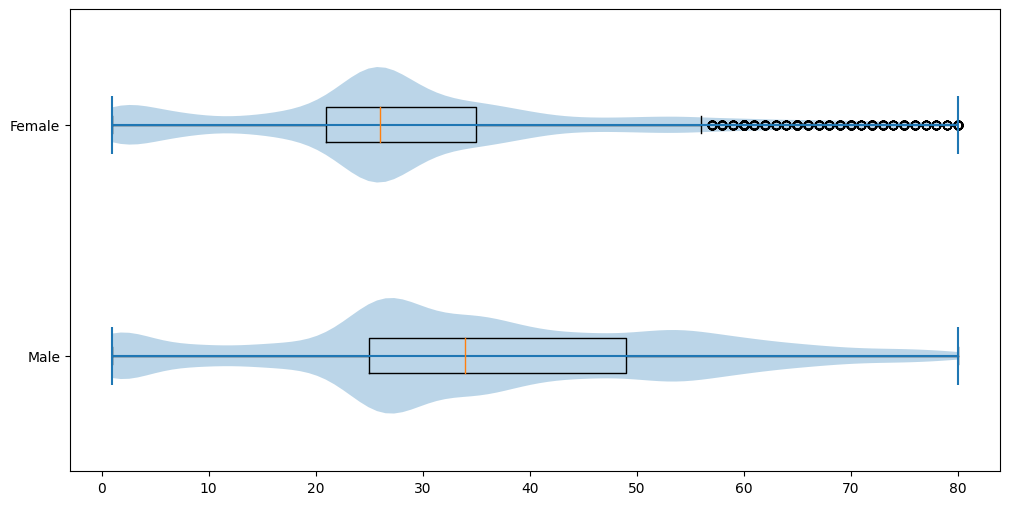

In [ ]:
plt.figure(figsize=(12, 6))
plt.boxplot([df.age[df.gender == cat] for cat in df.gender.unique()], vert=False, labels=df.gender.unique());
plt.violinplot([df.age[df.gender == cat] for cat in df.gender.unique()], vert=False);

### 🟡 Ethnicity violin and box plots

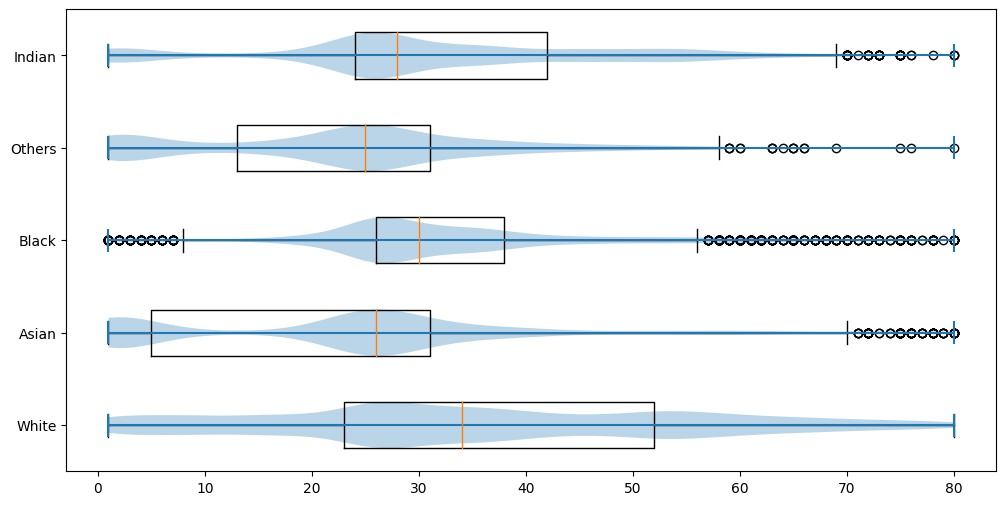

In [ ]:
plt.figure(figsize=(12, 6))
plt.boxplot([df.age[df.ethnicity == cat] for cat in df.ethnicity.unique()], vert=False, labels=df.ethnicity.unique());
plt.violinplot([df.age[df.ethnicity == cat] for cat in df.ethnicity.unique()], vert=False);

## 🟠 Split Datasets

In [ ]:
df_train, tmp = train_test_split(df, test_size=0.3, stratify=df.age, random_state=42)
df_test, df_valid = train_test_split(tmp, test_size=0.5, stratify=tmp.age, random_state=42)

df_train.shape, df_test.shape, df_valid.shape

((16215, 4), (3475, 4), (3475, 4))

In [ ]:
df_train.head()

,image_name,age,ethnicity,gender
6940,58_0_0_20170111171747501.jpg.chip.jpg,58,White,Male
4142,24_0_3_20170119165947103.jpg.chip.jpg,24,Indian,Male
16426,28_0_3_20170119194808322.jpg.chip.jpg,28,Indian,Male
1176,6_1_2_20161219153411316.jpg.chip.jpg,6,Asian,Female
14811,52_0_0_20170116183903737.jpg.chip.jpg,52,White,Male


###🟡 Age histograms in the training, validation, and test sets

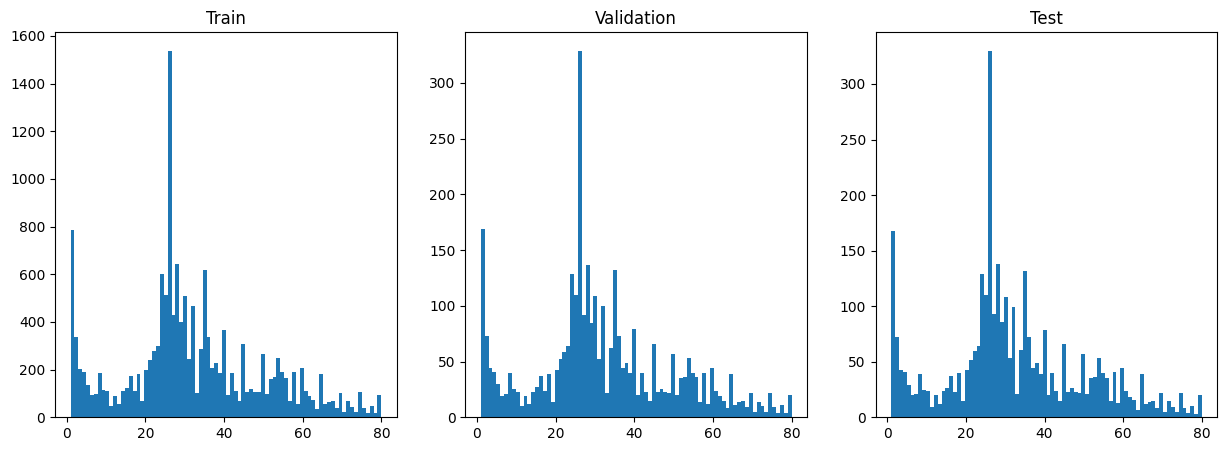

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

### 🟡 Saving the training, validation, and test sets in separate CSV files

In [ ]:
df_train.to_csv('/content/train_set.csv', index=False)
df_valid.to_csv('/content/valid_set.csv', index=False)
df_test.to_csv('/content/test_set.csv', index=False)

print('All CSV files created successfully.')

All CSV files created successfully.


## 🟠 Define Transformations

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 🟠 Custom Dataset

In [ ]:
class UTKDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None):
      self.root_dir = root_dir
      self.csv_file = csv_file
      self.transform = transform

      self.data = pd.read_csv(csv_file)

      self.gender_dict = {'Male': 0, 'Female': 1}
      self.ethnicity_dict = {'White': 0, 'Black': 1, 'Asian': 2, 'Indian':3, 'Others': 4}

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      sample = self.data.iloc[idx, :]

      image_name = sample.image_name
      image = Image.open(os.path.join(self.root_dir, image_name))

      age = torch.tensor([sample.age], dtype=torch.float32)
      gender = torch.tensor(self.gender_dict[sample.gender], dtype=torch.int32)
      ethnicity = torch.tensor(self.ethnicity_dict[sample.ethnicity], dtype=torch.int32)

      image = self.transform(image)

      return image, age#, gender, ethnicity

In [ ]:
temp_dataset = UTKDataset(root_dir='/content/UTKFace',
                          csv_file='/content/valid_set.csv',
                          transform=test_transform)

temp_dataset.data.head(), len(temp_dataset)
temp_dataset[0][1]

tensor([68.])

In [ ]:
dataset_dir = '/content/UTKFace'

train_set = UTKDataset(root_dir=dataset_dir,
                       csv_file='/content/train_set.csv',
                       transform=train_transform)

test_set = UTKDataset(root_dir=dataset_dir,
                      csv_file='/content/test_set.csv',
                      transform=test_transform)

valid_set = UTKDataset(root_dir=dataset_dir,
                       csv_file='/content/valid_set.csv',
                       transform=test_transform)

In [ ]:
idx = random.randint(0, len(train_set))
img, age = train_set[idx]
print('Age:', int(age.item()))
img

Age: 16


tensor([[[-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
         [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
         [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
         ...,
         [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
         [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
         [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665]],

        [[-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
         [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
         [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
         ...,
         [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
         [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
         [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832]],

        [[-1.7522, -1.7522, -1.7522,  ..., -1.7522, -1.7522, -1.7522],
         [-1.7522, -1.7522, -1.7522,  ..., -1

## 🟠 Define Dataloader

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=256, shuffle=False)

### 🟡 Testing the dataloader

In [ ]:
train_iter = iter(train_loader)
train_iter

In [ ]:
images, ages = next(train_iter)
images.shape, ages.shape

(torch.Size([128, 3, 128, 128]), torch.Size([128, 1]))

# 🔴 **Model**

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class AgeEstimationModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

  def forward(self, x):
    y = self.model(x)
    return y

In [ ]:
model = AgeEstimationModel()
model(images).shape

torch.Size([128, 1])

# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = nn.L1Loss()

In [ ]:
optimizer = optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
metric = tm.MeanAbsoluteError().to(device)

# 🔴 **Train**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

    return model, loss_train.avg, metric.compute().item()

In [ ]:
# train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=1)

# 🔴 **Evaluation**

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item())

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

In [ ]:
# evaluate(model, valid_loader, loss_fn, metric)

# 🔴 **Training Process**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculating the loss for an untrained model using a few batches


In [ ]:
model = AgeEstimationModel().to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

tensor(32.8268, device='cuda:0')


### 🟡 **Step 2:** Overfitting the model on a small subset of the dataset (loss → 0)

In [ ]:
mini_train_size = 1000
_, min_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(min_train_dataset, 20)

In [ ]:
model = AgeEstimationModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 9: 100%|██████████| 50/50 [00:08<00:00,  5.77batch/s, loss=4.56, metric=4.56]


### 🟡 **Step 3:** Training the model for a limited number of epochs, experimenting with various learning rates

In [ ]:
num_epochs = 3

for lr in [0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')

  model = AgeEstimationModel().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR=0.1


Epoch 2: 100%|██████████| 127/127 [02:00<00:00,  1.06batch/s, loss=9.12, metric=9.12]



LR=0.01


Epoch 2: 100%|██████████| 127/127 [02:00<00:00,  1.06batch/s, loss=6.25, metric=6.25]



LR=0.001


Epoch 2: 100%|██████████| 127/127 [01:59<00:00,  1.06batch/s, loss=5.98, metric=5.98]



LR=0.0001


Epoch 2: 100%|██████████| 127/127 [01:59<00:00,  1.07batch/s, loss=12.8, metric=12.8]

### 🟡 **Step 4**: Creating a small grid using the weight decay and the best learning rate





In [ ]:
num_epochs = 5

for lr in [0.005, 0.003, 0.001, 0.0007, 0.0005]:
  if lr == 0.001:
    continue

  for wd in [1e-4, 1e-5, 0.]:
    print(f'LR={lr}, WD={wd}')

    model = AgeEstimationModel().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

LR=0.005, WD=0.0001


Epoch 4: 100%|██████████| 127/127 [02:00<00:00,  1.06batch/s, loss=5.4, metric=5.4]



LR=0.005, WD=1e-05


Epoch 4: 100%|██████████| 127/127 [01:59<00:00,  1.06batch/s, loss=5.53, metric=5.53]



LR=0.005, WD=0.0


Epoch 4: 100%|██████████| 127/127 [01:59<00:00,  1.06batch/s, loss=5.52, metric=5.52]



LR=0.003, WD=0.0001


Epoch 4: 100%|██████████| 127/127 [02:00<00:00,  1.06batch/s, loss=5.81, metric=5.81]



LR=0.003, WD=1e-05


Epoch 4: 100%|██████████| 127/127 [01:58<00:00,  1.07batch/s, loss=5.8, metric=5.8]



LR=0.003, WD=0.0


Epoch 4: 100%|██████████| 127/127 [01:58<00:00,  1.07batch/s, loss=5.77, metric=5.77]



LR=0.0007, WD=0.0001


Epoch 4: 100%|██████████| 127/127 [02:01<00:00,  1.05batch/s, loss=8.29, metric=8.29]



LR=0.0007, WD=1e-05


Epoch 4: 100%|██████████| 127/127 [02:00<00:00,  1.05batch/s, loss=8.19, metric=8.19]



LR=0.0007, WD=0.0


Epoch 4: 100%|██████████| 127/127 [02:01<00:00,  1.05batch/s, loss=8.22, metric=8.22]



LR=0.0005, WD=0.0001


Epoch 4: 100%|██████████| 127/127 [01:59<00:00,  1.06batch/s, loss=11.8, metric=11.8]



LR=0.0005, WD=1e-05


Epoch 4: 100%|██████████| 127/127 [02:01<00:00,  1.04batch/s, loss=11.6, metric=11.6]



LR=0.0005, WD=0.0


Epoch 4: 100%|██████████| 127/127 [01:59<00:00,  1.06batch/s, loss=11.9, metric=11.9]

## 🟠 Main Loop





📌 Training the model for longer epochs using the best hyperparameters from **Step 4**

In [ ]:
model = AgeEstimationModel().to(device)

In [ ]:
lr = 0.005
wd = 1e-4

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  # Validation
  loss_valid, metric_valid = evaluate(model, valid_loader, loss_fn, metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, MAE = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=4.46, metric=4.46]


Model Saved!
Valid: Loss = 5.077, MAE = 5.069



Epoch 1: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=4.44, metric=4.44]


Model Saved!
Valid: Loss = 5.073, MAE = 5.065



Epoch 2: 100%|██████████| 127/127 [02:02<00:00,  1.04batch/s, loss=4.46, metric=4.46]


Model Saved!
Valid: Loss = 5.072, MAE = 5.064



Epoch 3: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=4.47, metric=4.47]


Valid: Loss = 5.082, MAE = 5.074



Epoch 4: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=4.48, metric=4.48]


Valid: Loss = 5.094, MAE = 5.086



Epoch 5: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=4.48, metric=4.48]


Model Saved!
Valid: Loss = 5.065, MAE = 5.057



Epoch 6: 100%|██████████| 127/127 [02:02<00:00,  1.04batch/s, loss=4.41, metric=4.41]


Model Saved!
Valid: Loss = 5.057, MAE = 5.05



Epoch 7: 100%|██████████| 127/127 [02:02<00:00,  1.04batch/s, loss=4.45, metric=4.45]


Valid: Loss = 5.088, MAE = 5.08



Epoch 8: 100%|██████████| 127/127 [02:02<00:00,  1.04batch/s, loss=4.48, metric=4.48]


Valid: Loss = 5.069, MAE = 5.062



Epoch 9: 100%|██████████| 127/127 [02:02<00:00,  1.04batch/s, loss=4.47, metric=4.47]


Valid: Loss = 5.071, MAE = 5.064



### 🟡 Saving the best model

In [ ]:
!cp "/content/model.pt" "/content/drive/MyDrive/model"

## 🟠 Plotting Learning Curves

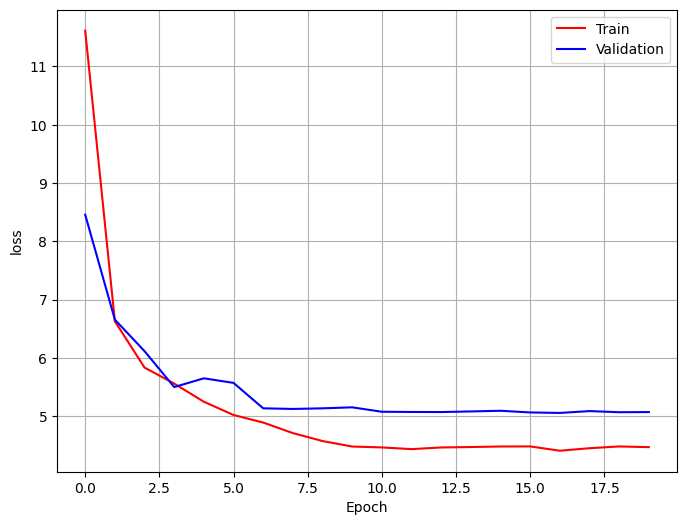

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

In [ ]:
model_path = '/content/model.pt'
model = torch.load(model_path)
model.eval()

AgeEstimationModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
_, metric_train = evaluate(model, train_loader, loss_fn, metric)
_, metric_valid = evaluate(model, valid_loader, loss_fn, metric)
_, metric_test = evaluate(model, test_loader, loss_fn, metric)

metric_train, metric_valid, metric_test

(4.346529006958008, 5.049502372741699, 5.029848098754883)

# 🔴 **Inference**

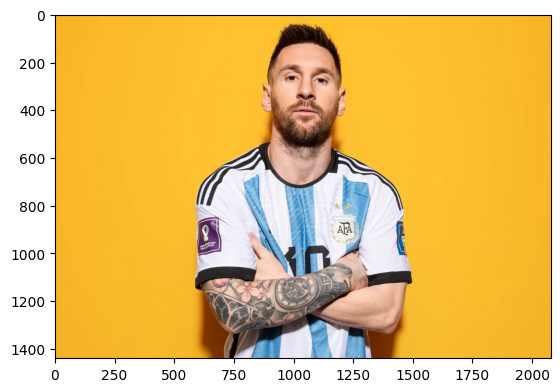

In [ ]:
img = Image.open('/content/pic.png')
plt.imshow(img)

In [ ]:
def inference(image_path, transform, model, face_detection=False):
  if face_detection:
    img = face_recognition.load_image_file(image_path)
    top, right, bottom, left = face_recognition.face_locations(img)[0]
    img_crop = img[top:bottom, left:right]
    img_crop = Image.fromarray(img_crop) # convert numpy_array to PIL
  else:
      img_crop = Image.open(image_path).convert('RGB')

  img_tensor = transform(img_crop).unsqueeze(0)
  with torch.inference_mode():
    pred = model(img_tensor.to(device)).item()

  return pred, img_crop

40.39


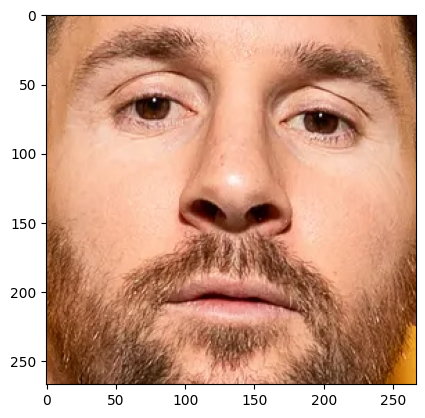

In [ ]:
pred, img_full = inference('pic.png', test_transform, model, face_detection=True)

print(f'{pred:.2f}')
plt.imshow(img_full)

## 🟠 Loading a random image from a folder

Real: 5, Predicted: 5.47


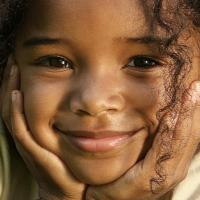

In [ ]:
folder_image_path = '/content/UTKFace/'
image_files = os.listdir(folder_image_path)

rand_idx = random.randint(0, len(image_files))
test_image_path = os.path.join(folder_image_path, image_files[rand_idx])
predicted_age, image = inference(test_image_path, test_transform, model, face_detection=False)

real_age = image_files[rand_idx].split('_')[0]
print(f"Real: {real_age}, Predicted: {predicted_age:.2f}")
image

## 🟠 Loading a random image from a csv file

Real: 26, Predicted: 24.44


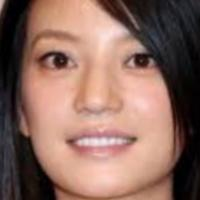

In [ ]:
csv_file_path = '/content/test_set.csv'
df = pd.read_csv(csv_file_path)

rand_idx = random.randint(0, df.shape[0])
test_image_name = df.iloc[rand_idx].image_name
test_image_path = os.path.join(folder_image_path, test_image_name)
predicted_age, image = inference(test_image_path, test_transform, model, face_detection=False)

real_age = test_image_name.split('_')[0]
print(f"Real: {real_age}, Predicted: {predicted_age:.2f}")
image

# 🔴 **Experiments**

## 🟠 Analyzing the MAE Value

In [ ]:
all_outputs = []
all_targets = []

for inputs, targets in test_loader:
  inputs = inputs.to(device)
  targets = targets.to(device)

  with torch.inference_mode():
    outputs = model(inputs)

  all_outputs.append(outputs)
  all_targets.append(targets)

all_outputs = torch.vstack(all_outputs).squeeze()
all_targets = torch.vstack(all_targets).squeeze()
all_outputs.shape, all_targets.shape

(torch.Size([3475]), torch.Size([3475]))

In [ ]:
mae = F.l1_loss(all_outputs, all_targets, reduction='none')
mae.shape

torch.Size([3475])

In [ ]:
df_test = pd.read_csv('/content/test_set.csv')

df_test['preds'] = all_outputs.cpu()
df_test['maes'] = mae.cpu()

df_test.to_csv('/content/test_outputs.csv')
df_test.head()

,image_name,age,ethnicity,gender,preds,maes
0,56_0_0_20170105173129526.jpg.chip.jpg,56,White,Male,60.189877,4.189877
1,48_0_2_20170104212013870.jpg.chip.jpg,48,Asian,Male,46.751438,1.248562
2,34_0_3_20170119165834583.jpg.chip.jpg,34,Indian,Male,32.701744,1.298256
3,46_1_1_20170113184212578.jpg.chip.jpg,46,Black,Female,38.662987,7.337013
4,4_1_0_20170109193436148.jpg.chip.jpg,4,White,Female,4.695219,0.695219


In [ ]:
df_test.groupby('age')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
1,168.0,0.850548,4.684723,0.000689,0.179268,0.387452,0.578844,60.674683
2,72.0,0.988244,1.036948,0.007067,0.493955,0.738953,1.208048,5.785958
3,43.0,1.526484,2.416550,0.042792,0.496820,1.251306,1.725976,16.166458
4,41.0,2.162234,2.950567,0.050956,0.641127,1.547958,2.659445,18.115070
5,29.0,2.608448,1.991307,0.267978,1.373264,2.081116,2.955789,9.400366
...,...,...,...,...,...,...,...,...
76,8.0,9.717020,9.523916,0.183357,1.986328,7.054485,14.787330,24.072456
77,4.0,4.789167,5.321898,0.098602,1.494141,3.428146,6.723173,12.201775
78,10.0,7.677895,4.652892,0.418488,4.686640,6.459366,11.852144,14.765591


<BarContainer object of 80 artists>

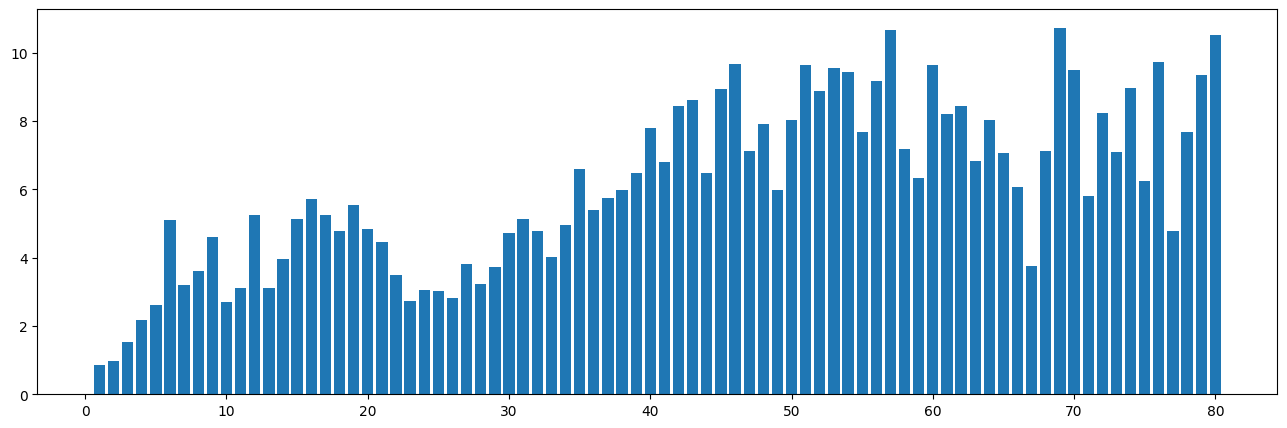

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(df_test.groupby('age')['maes'].describe().index,
        df_test.groupby('age')['maes'].describe()['mean'])

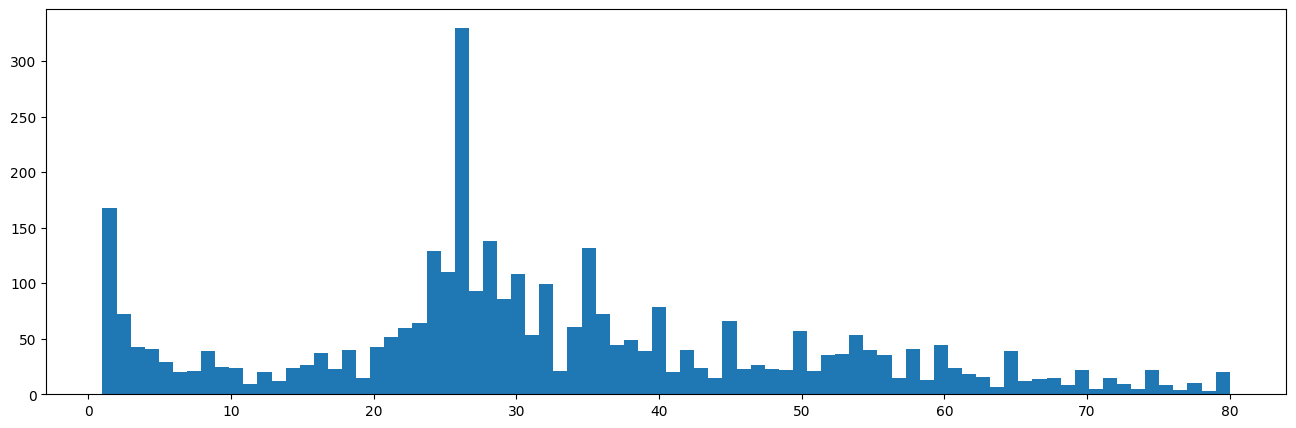

In [ ]:
plt.figure(figsize=(16, 5))
plt.hist(df_test.age, bins=len(df_test.age.unique()));

In [ ]:
df_test.groupby('gender')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,1665.0,4.786103,5.241536,0.000366,1.222134,3.028708,6.503468,43.349960
Male,1810.0,5.254066,5.003134,0.001616,1.591433,3.896342,7.557925,60.674683


In [ ]:
df_test.groupby('ethnicity')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
ethnicity,,,,,,,,
Asian,520.0,3.931533,5.143181,0.005465,0.745248,2.246737,5.225433,60.674683
Black,686.0,5.578426,5.373424,0.008343,1.720691,3.906029,7.693942,38.808475
Indian,603.0,4.892252,4.684767,0.001616,1.228792,3.573849,7.342453,26.182476
Others,269.0,4.107219,4.214105,0.007067,1.255450,2.602045,5.953686,23.817375
White,1397.0,5.406338,5.247257,0.000366,1.630169,3.899715,7.549911,43.349960


In [ ]:
ranges = np.arange(df.age.min()-1, df.age.max()+1, 5)
df_test['age_period'] = pd.cut(df.age, bins=ranges)
df_test.head()

,image_name,age,ethnicity,gender,preds,maes,age_period
0,56_0_0_20170105173129526.jpg.chip.jpg,56,White,Male,60.189877,4.189877,"(55, 60]"
1,48_0_2_20170104212013870.jpg.chip.jpg,48,Asian,Male,46.751438,1.248562,"(45, 50]"
2,34_0_3_20170119165834583.jpg.chip.jpg,34,Indian,Male,32.701744,1.298256,"(30, 35]"
3,46_1_1_20170113184212578.jpg.chip.jpg,46,Black,Female,38.662987,7.337013,"(45, 50]"
4,4_1_0_20170109193436148.jpg.chip.jpg,4,White,Female,4.695219,0.695219,"(0, 5]"


<ipython-input-110-e23c6f257617>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test.groupby('age_period')['maes'].describe()['mean']);


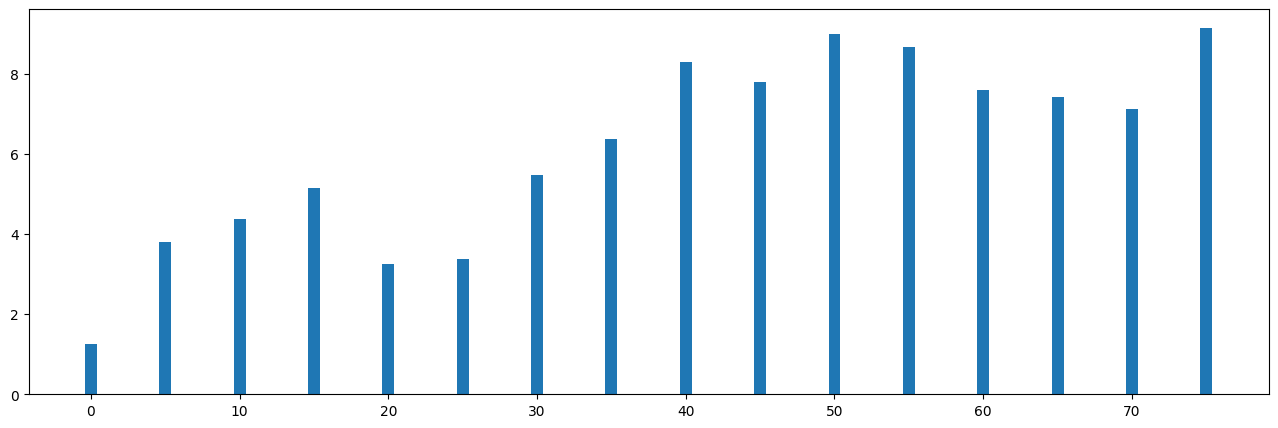

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(ranges[:-1],
        df_test.groupby('age_period')['maes'].describe()['mean']);

In [ ]:
df_test.groupby('age_period')['maes'].describe()

<ipython-input-114-b31b92349ac2>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test.groupby('age_period')['maes'].describe()


,count,mean,std,min,25%,50%,75%,max
age_period,,,,,,,,
"(0, 5]",353.0,1.257737,3.602635,0.000689,0.295855,0.609304,1.282938,60.674683
"(5, 10]",129.0,3.797065,4.490601,0.041216,1.220013,2.386587,4.666656,38.808475
"(10, 15]",91.0,4.373603,4.307884,0.038651,1.238796,2.695910,5.409784,21.589268
"(15, 20]",158.0,5.154958,3.152900,0.083832,2.808524,4.828447,6.940024,20.294048
"(20, 25]",415.0,3.241995,3.213197,0.005465,1.149637,2.439114,4.217493,24.081944
"(25, 30]",755.0,3.389088,3.139806,0.000366,1.199689,2.429600,4.513359,18.942547
"(30, 35]",366.0,5.475138,3.949572,0.037083,2.431842,5.040693,7.447608,23.742977
"(35, 40]",283.0,6.375100,4.816052,0.008343,2.477520,5.590961,9.192214,27.567307
"(40, 45]",165.0,8.290783,5.532408,0.280724,4.060139,7.160473,11.802910,29.782434
